In [1]:
import proplot as pplt
import matplotlib as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from sklearn.linear_model import TheilSenRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def prepare_data(prcp_filepath, area_filepath):
    prcp = pd.read_csv(prcp_filepath)
    area = pd.read_csv(area_filepath)

    dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)
    county = gpd.read_file('./Data/counties_2021.geojson')
    county = county.to_crs(dest_crs)[['ADM2_NAME', 'geometry']]

    combined = gpd.GeoDataFrame(pd.concat([prcp, area, county], axis=1))
    combined['total_prcp_per_area'] = combined['total']/combined.geometry.area
    combined['recent_prcp_per_area'] = combined['recent']/combined.geometry.area
    combined['anom_prcp_per_area'] = combined['anom']/combined.geometry.area
    combined['perc_defol_area'] = combined['sum']/combined['count']
    
    return combined

In [3]:
def exploratory_figure(combined):
    fig, axes = pplt.subplots(ncols=3, sharex=False)
    
    # Mean Yearly Precipitation
    coef = np.polyfit(combined['total'],combined['perc_defol_area'],1)
    poly1d_fn = np.poly1d(coef) 
    xs = np.array([combined['total'].min(), combined['total'].max()])

    axes[0].scatter(combined['total'], combined['perc_defol_area'])
    axes[0].plot(xs, poly1d_fn(xs))
    axes[0].format(xlabel='Mean Precipitation (mm/ha)', ylabel='% of Area Defoliated')
    
    # Past Year Precipitation
    coef = np.polyfit(combined['recent'],combined['perc_defol_area'],1)
    poly1d_fn = np.poly1d(coef)
    xs = np.array([combined['recent'].min(), combined['recent'].max()])
    
    axes[1].scatter(combined['recent'], combined['perc_defol_area'])
    axes[1].plot(xs, poly1d_fn(xs))
    axes[1].format(xlabel='Past Year Precipitation (mm/ha)', ylabel='% of Area Defoliated')
    
    # Past Year Anomaly
    coef = np.polyfit(combined['anom'],combined['perc_defol_area'],1)
    poly1d_fn = np.poly1d(coef)
    xs = np.array([combined['anom'].min(), combined['anom'].max()])

    lin_reg = TheilSenRegressor()
    lin_reg.fit(combined['anom'].array.reshape(-1, 1), combined['perc_defol_area'])
    y = lin_reg.predict(xs.reshape(-1, 1))

    axes[2].scatter(combined['anom'], combined['perc_defol_area'])
    axes[2].plot(xs, poly1d_fn(xs), label='OLS')
    axes[2].plot(xs, y, label='Theil-Sen')    
    axes[2].format(xlabel='Precipitation Anomaly (mm/ha)', ylabel='% of Area Defoliated')
    ax.legend(ncols=1)

In [13]:
def quantile_regression(combined, x_variable, xlabel, save=False, filename=''):
    quantiles = [0.25, 0.5, 0.75]

    # fit the model
    models = [smf.quantreg(f'perc_defol_area ~ {x_variable}', combined).fit(q=q)
              for q in quantiles]
    
    fig, ax = pplt.subplots(figsize=('90mm','90mm'))

    xs = np.array([combined[x_variable].min(), combined[x_variable].max()])
    ys = [model.params['Intercept'] + xs*model.params[x_variable] for model in models]

    ax.scatter(combined[x_variable], combined['perc_defol_area'], color='darkgray', ms=10, label='')
    linestyles = ['dotted', 'dashed', 'solid']
    for i, y in enumerate(ys):
        ax.plot(xs, y, label=f'q = {quantiles[i]}', linestyle=linestyles[i], color='black')

    ax.legend(ncols=1)
    ax.format(xlabel=xlabel, ylabel='% of Area Defoliated')
    if save:
        fig.savefig(filename)
        
    return models

## One Month 2021

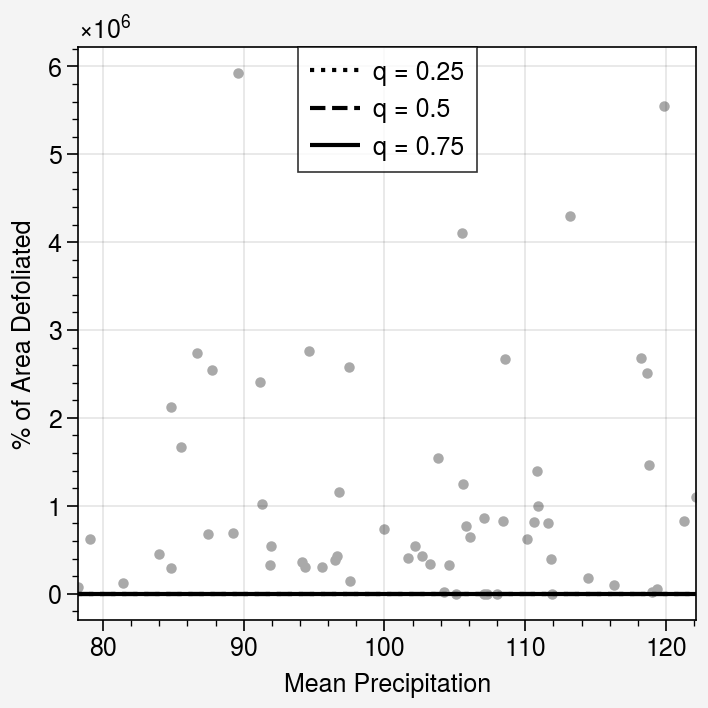

In [7]:
combined = prepare_data('./Data/Enviro/prcp_one_month_county_2021.csv', './Data/Enviro/defol_area_county_2021.csv')
#exploratory_figure(combined)
quantile_regression(combined, x_variable='total', xlabel='Mean Precipitation')

## Three Month 2021

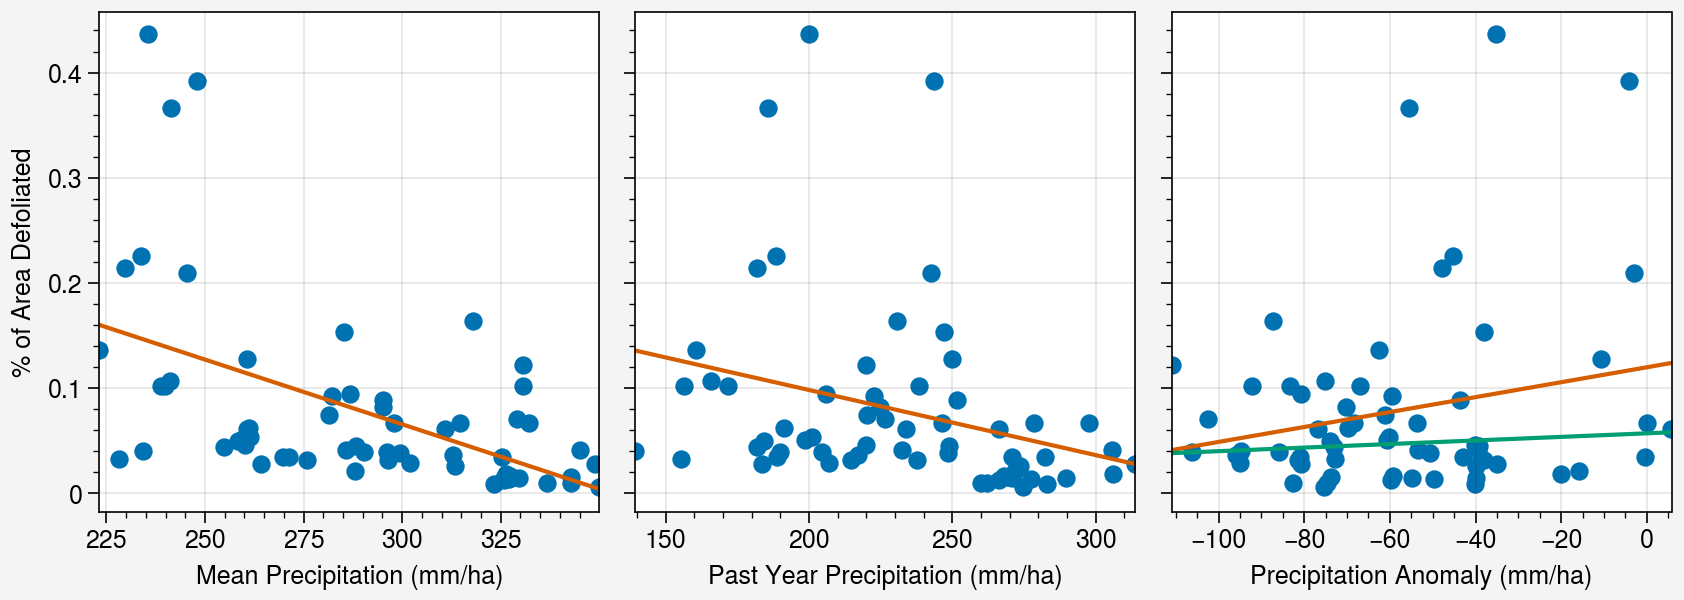

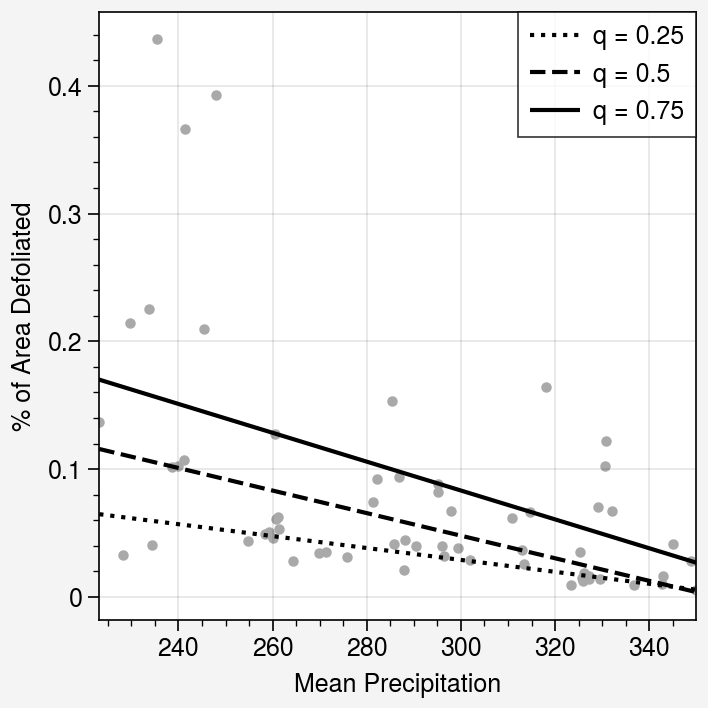

In [195]:
combined = prepare_data('./Data/Enviro/prcp_three_month_county_2021.csv', './Data/Enviro/defol_area_county_2021.csv')
exploratory_figure(combined)
quantile_regression(combined, x_variable='total', xlabel='Mean Precipitation')

## Six Month

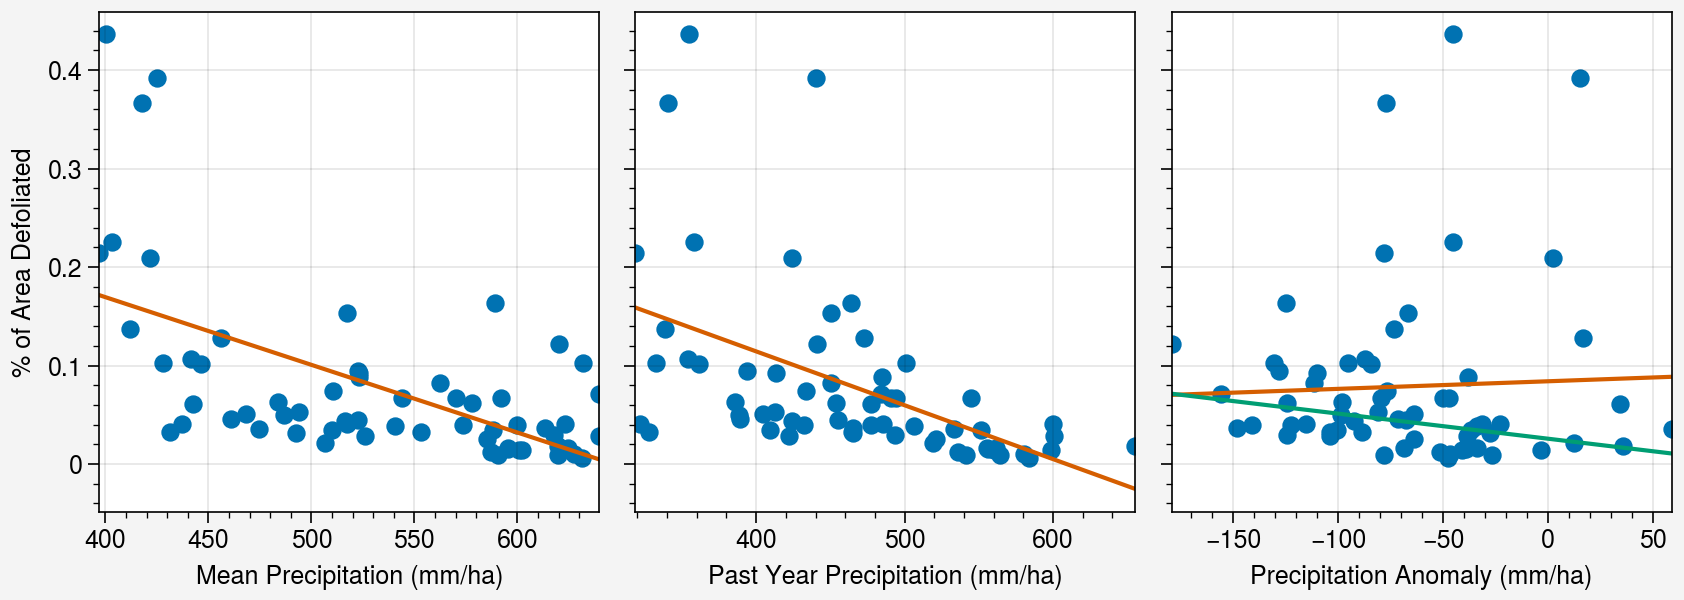

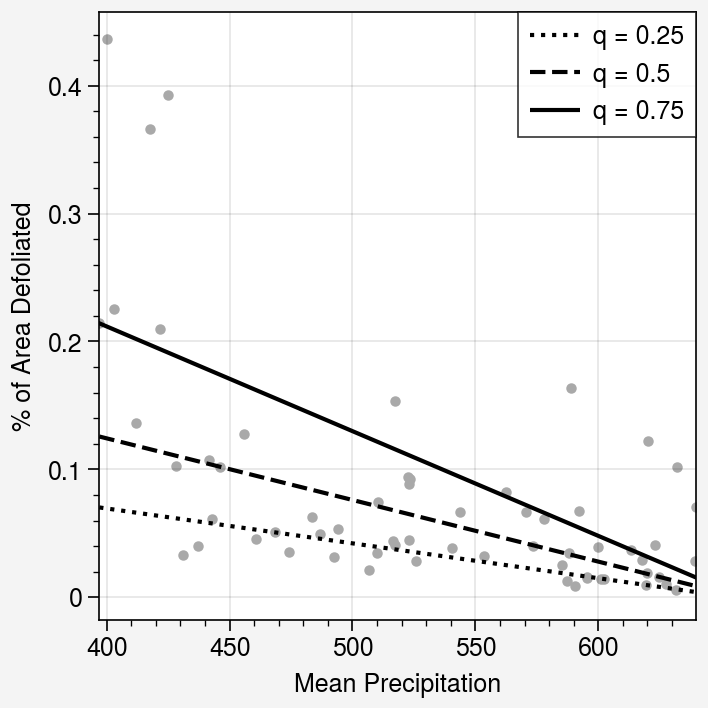

In [196]:
combined = prepare_data('./Data/Enviro/prcp_six_month_county_2021.csv', './Data/Enviro/defol_area_county_2021.csv')
exploratory_figure(combined)
quantile_regression(combined, x_variable='total', xlabel='Mean Precipitation')

## Twelve Month 2021

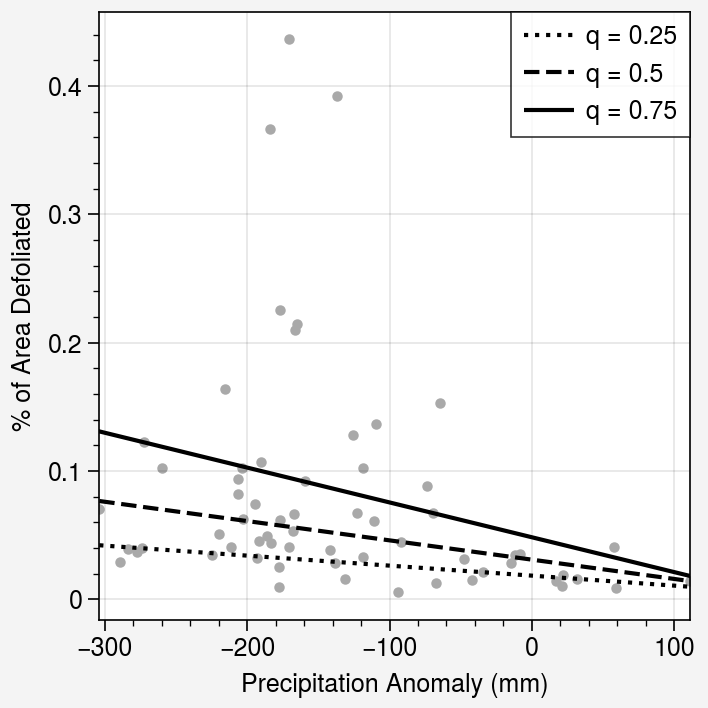

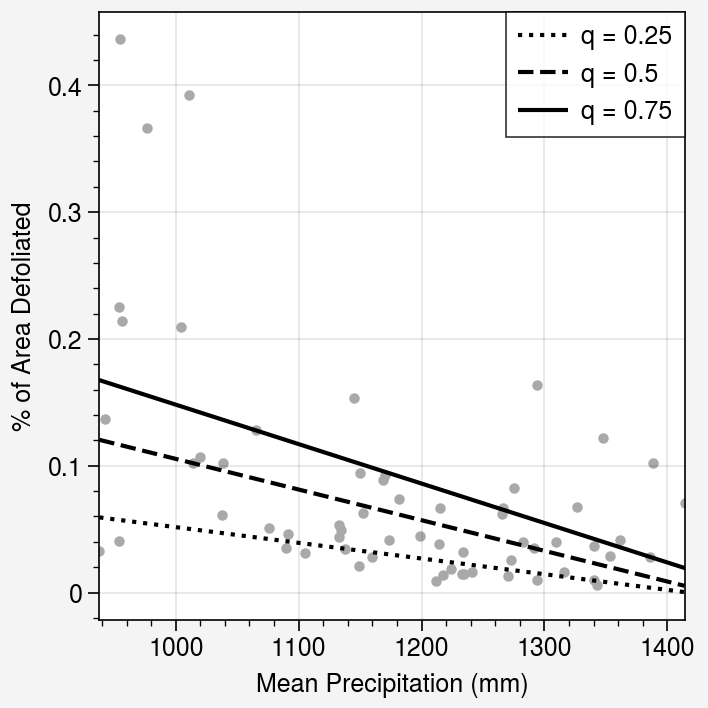

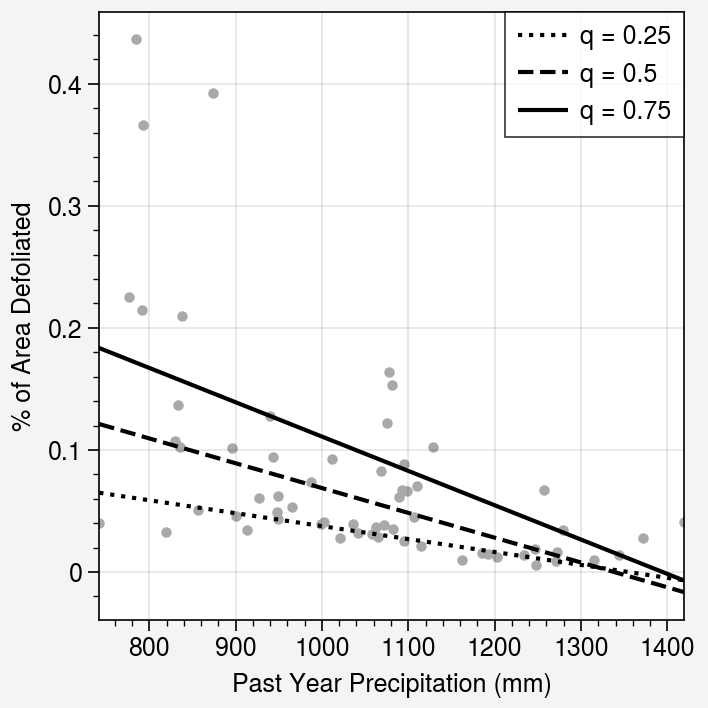

In [14]:
combined = prepare_data('./Data/Enviro/prcp_twelve_month_county_2021.csv', './Data/Enviro/defol_area_county_2021.csv')
#exploratory_figure(combined)
anom_models = quantile_regression(combined, 'anom', 'Precipitation Anomaly (mm)', False, './Figures/Enviro/prcp_anom_quantile.png')
total_models = quantile_regression(combined, 'total', 'Mean Precipitation (mm)', False, './Figures/Enviro/prcp_mean_quantile.png')
recent_models = quantile_regression(combined, 'recent', 'Past Year Precipitation (mm)', False, './Figures/Enviro/prcp_quantile.png')

In [15]:
print(anom_models[0].summary())
print(anom_models[1].summary())
print(anom_models[2].summary())

                         QuantReg Regression Results                          
Dep. Variable:        perc_defol_area   Pseudo R-squared:              0.07961
Model:                       QuantReg   Bandwidth:                     0.05652
Method:                 Least Squares   Sparsity:                       0.1208
Date:                Tue, 14 Jan 2025   No. Observations:                   62
Time:                        11:41:37   Df Residuals:                       60
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0184      0.012      1.485      0.143      -0.006       0.043
anom       -7.794e-05   7.92e-05     -0.985      0.329      -0.000    8.04e-05
                         QuantReg Regression Results                          
Dep. Variable:        perc_defol_area   Pseudo R-squ

In [16]:
print(total_models[0].summary())
print(total_models[1].summary())
print(total_models[2].summary())

                         QuantReg Regression Results                          
Dep. Variable:        perc_defol_area   Pseudo R-squared:              0.05813
Model:                       QuantReg   Bandwidth:                     0.05416
Method:                 Least Squares   Sparsity:                       0.1269
Date:                Tue, 14 Jan 2025   No. Observations:                   62
Time:                        11:41:50   Df Residuals:                       60
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1753      0.059      2.952      0.004       0.057       0.294
total         -0.0001   5.02e-05     -2.465      0.017      -0.000   -2.33e-05

The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.


In [17]:
print(recent_models[0].summary())
print(recent_models[1].summary())
print(recent_models[2].summary())

                         QuantReg Regression Results                          
Dep. Variable:        perc_defol_area   Pseudo R-squared:               0.1508
Model:                       QuantReg   Bandwidth:                     0.04759
Method:                 Least Squares   Sparsity:                       0.1105
Date:                Tue, 14 Jan 2025   No. Observations:                   62
Time:                        11:42:24   Df Residuals:                       60
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1436      0.039      3.688      0.000       0.066       0.221
recent        -0.0001    3.7e-05     -2.865      0.006      -0.000    -3.2e-05

The condition number is large, 6.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
